**Nesse código será a minha primeira tentativa de praticar uma série temporal. Neste exemplo usaremos dados referentes a alguma ação na bolsa de valores.**

Uma série temporal nada mais que uma coleção de observações feitas sequencialmente ao longo do tempo. Elas são muito utilizadas em finanças, vendas, marketing, e etc.

Mais infos sobre séries temporais aqui: https://pt.wikipedia.org/wiki/S%C3%A9rie_temporal

Vou tentar aplicar alguns métodos como a autocorrelação total, autocorrelação parcial e teste de AdFuller

Além disso, vamos visualizar também a Variação Percentual da Ação por um período de tempo.

E por fim, vamos tentar prever algo.

![](https://www.nasdaq.com/sites/acquia.prod/files/2020/03/16/stocks-iamchamp-adobe.jpg?453118834)

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader

import warnings
warnings.filterwarnings("ignore")


Para extrair os dados das ações vou utilizar o DataReader da biblioteca do pandas_datareader.data.

É extramemente útil utilizar essa biblioteca porque ela pega dados reais através do site do **yahoo finance** ('https://finance.yahoo.com/')

## Importando dados

In [2]:
start = '2012-01-01'
df = pd.DataFrame(DataReader('FLRY3.SA', data_source = 'yahoo',
               start = start)['Adj Close'])

In [3]:
df.head()

,Adj Close
Date,
2012-01-02,6.271790
2012-01-03,6.398283
2012-01-04,6.357100
2012-01-05,6.324740
2012-01-06,6.354157


Nos vamos utilizar a Coluna Adj Close porque é a coluna de **fechamento do preço da ação do dia**

## Checando os dados

Verificando dados nulos

In [4]:
df.isna().sum()

Adj Close    0
dtype: int64

Não temos dados nulos neste dataset

Vamos visualizando mais os dados

In [5]:
df.describe()

,Adj Close
count,2128.000000
mean,13.933251
std,8.535797
min,4.604617
25%,6.033025
50%,8.911078
75%,22.878417
max,32.830769


O describe é um bom método pra identificarmos se existem alguns dados muito distantes (min e max), porém observamos que não há uma discrepância tão grande entre os preços. Aparentemente normal

Agora vamos plotar nosso primeiro gráfico. Esse gráfico que vou plotar será **como está o preço da ação ao longo do tempo**

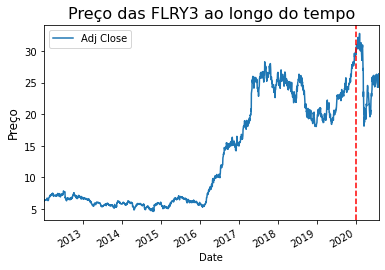

In [8]:
df.plot()
plt.title("Preço das FLRY3 ao longo do tempo", fontsize = 16)
plt.axvline('2020', linestyle = '--', color = 'r')
plt.ylabel('Preço', fontsize = 12);

Nesse gráfico observamos como depois do ano de **2020** com o corona virus as ações da FLRY3 despencaram, assim como todas as outras ações.

Fora isso é perceptível que a partir do ano de 2016 a FLRY3 teve uma valorização muito alta comparado com os anos anteriores


Agora, vamos plotar o gráfico com a **Variação % do preço da ação** durante o mesmo período

Com esse gráfico podemos ter uma noção se essa série é estacionária ou não. Como há um aumento do preço de 2016 e 2017 houve uma alteração nas médias, portanto pressupõe que essa série não é estacionária.

Para uma série ser estacionária os valores devem flutuar em torno de uma **mesma média ao longo do tempo**. E no exemplo é claro que as médias são distintas ao longo do tempo

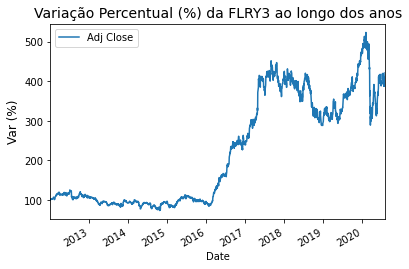

In [16]:
(df/df.iloc[0]*100).plot()
plt.title('Variação Percentual (%) da FLRY3 ao longo dos anos', fontsize = 14)
plt.ylabel('Var (%)', fontsize = 12);

# Autocorrelação Total e Parcial

Vamos visualizar a autocorrelação total dos dados. A Autocorrelação total (ACF) é um cálculo que permite identificar o quanto que os valores aleatórias influenciam os seus vizinhos.

Em outras palavras, quanto que os dias anteriores (ou meses anteriores) influenciam os valores atuais.

Já a Autocorrelação Parcial (PACF)  de uma série de tempo com os seus próprios valores desfasados, controlando-se os valores da série de tempo em todos os desfasamentos mais curtos. Ele contrasta com a função de autocorrelação, que não controla para outros atrasos.

In [17]:
# importando a biblioteca que vamos utilizar o acf e pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

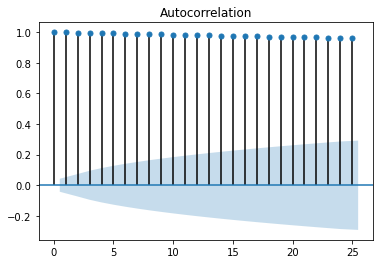

In [23]:
plot_acf(df, lags = 25);

Vemos nesse gráfico que há uma forte autocorrelação entre os valores. 

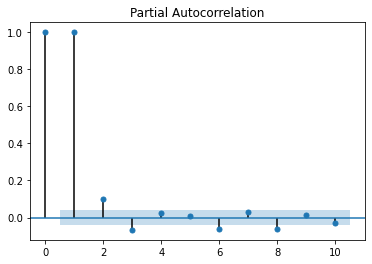

In [22]:
plot_pacf(df, lags = 10);

Com essas características parece um modelo M.A (Moving Average)

## Teste AdFuller (Estacionariedade)

In [25]:
# importando biblioteca para fazer o teste
from statsmodels.tsa.stattools import adfuller

In [26]:
p1 = adfuller(df['Adj Close'])[1]
print('p-valor', p1)

if p1 < 0.05:
    print('É uma série estacionária')
else:
    print('É uma random walk')


p-valor 0.8897024408115078
É uma random walk


Pelo teste estatístico de AdFuller, conforme havíamos previsto, não é uma série estacionária, portanto temos que transforma-la.

Para isso utilizaremos a função **diff**

In [28]:
df_diff = df.diff().dropna()
df_diff.head()

,Adj Close
Date,
2012-01-03,0.126494
2012-01-04,-0.041183
2012-01-05,-0.032360
2012-01-06,0.029417
2012-01-09,0.050010


A função diff faz a diferença da linha atual pela sua linha anterior. 

In [29]:
# Nesse caso temos 0.126494 que é o valor do iloc[0] da df_diff
df.iloc[1] - df.iloc[0]

Adj Close    0.126494
dtype: float64

Vamos visualizar agora nossos dados agora que eles estão transformados!

Text(0.5, 1.0, 'Flry3 transformado')

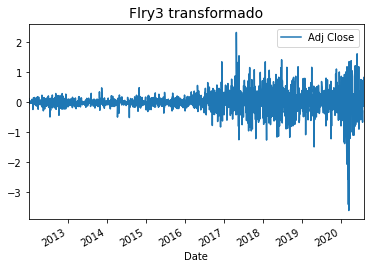

In [31]:
df_diff.plot();
plt.title('Flry3 transformado', fontsize = 14)

Com esse gráfico conseguimos visualizar que apesar de ter ainda uma volatilidade, temos uma média próxima em todos os pontos

Vamos refazer o teste de ADfuller para checar se está estacionário

In [32]:
p1 = adfuller(df_diff['Adj Close'])[1]
print('p-valor', p1)

if p1 < 0.05:
    print('É uma série estacionária')
else:
    print('É uma random walk')


p-valor 6.464838934841344e-15
É uma série estacionária


A série agora é uma série **estacionária.** 

Agora como próximos passos podemos aplicar o AIC para definir qual será o melhor modelo a ser testado por esse dataset

In [34]:
## Importando biblioteca
from statsmodels.tsa.arima_model import ARMA

In [35]:
ls_ar, ls_ma, ls_aic, ls_bic = [], [], [], []

for ar in range(0, 4):
    for ma in range(0, 4):
        mod = ARMA(df_diff, order=(ar, ma))
        res = mod.fit()
        
        ls_ar.append(ar)
        ls_ma.append(ma)
        ls_aic.append(res.aic)
        ls_bic.append(res.bic)

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [36]:
df_ic = pd.DataFrame({'AR': ls_ar, 'MA': ls_ma,
                      'AIC': ls_aic, 'BIC': ls_bic})

In [39]:
df_ic.sort_values(['AIC','BIC'])

,AR,MA,AIC,BIC
2,0,2,1573.341633,1595.991505
6,1,2,1573.625331,1601.937670
3,0,3,1574.198469,1602.510808
5,1,1,1578.105186,1600.755058
4,1,0,1585.486941,1602.474344
1,0,1,1587.956759,1604.944162
0,0,0,1599.822544,1611.147479


Entao temos o método **MA = 2 com o menor AIC**, é esse iremos testar afim de obter alguma previsibilidade com relação ao nosso dataset

In [53]:
df_diff_ma2 = ARMA(df_diff, order = (0,2))
result = df_diff_ma2.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2127
Model:                     ARMA(0, 2)   Log Likelihood                -782.671
Method:                       css-mle   S.D. of innovations              0.350
Date:                Tue, 04 Aug 2020   AIC                           1573.342
Time:                        11:54:50   BIC                           1595.992
Sample:                             0   HQIC                          1581.632
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0095      0.008      1.242      0.214      -0.005       0.024
ma.L1.Adj Close    -0.0780      0.022     -3.595      0.000      -0.120      -0.035
ma.L2.Adj Close     0.0849      0.021      4.104      0.000       0.044       0.125
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            0.4594           -3.4015j            3.4323           -0.2286
MA.2            0.4594           +3.4015j            3.4323            0.2286
-----------------------------------------------------------------------------
"""

A Equação seria: $$Adj Close = -0.07 * V(T-1) + 0.08* V(T-2)$$

In [55]:
df_diff.shape

(2127, 1)

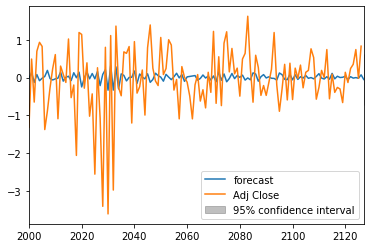

In [56]:
result.plot_predict(start = 2000, end = 2127)
plt.show()

Bom para uma primeira tentativa, estou bem satisfeito. Claro que não é o forecast que esperava xD!

Mas tem muitos pontos de melhoria! 

Obrigado pras pessoas que ficaram até aqui